# 1 Data cleaning and preprocessing

In [5]:
# importing the packaes
import pandas as pd
import numpy as np

In [7]:
# Load raw data
df=pd.read_csv(r"C:\Users\hp\Downloads\Dataset_Uber Traffic.csv")

In [9]:
# Read the dataset
df.head()

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


In [15]:
# Convert datetime colum to datetime type
df['DateTime'] = pd.to_datetime(df['DateTime'], dayfirst=True)
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d-%m-%Y %H:%M')

C:\Users\hp\AppData\Local\Temp\ipykernel_10384\2614390132.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateTime'] = pd.to_datetime(df['DateTime'], dayfirst=True)


In [17]:
# Handle missing values
df = df.fillna(method='ffill') 

C:\Users\hp\AppData\Local\Temp\ipykernel_10384\602833627.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [28]:
# Checking the duplicates
df.duplicated(df)

0        False
1        False
2        False
3        False
4        False
         ...  
48115    False
48116    False
48117    False
48118    False
48119    False
Length: 48120, dtype: bool

In [30]:
# Remove duplicates
df = df.drop_duplicates()

In [32]:
# Correct data types
df['Junction'] = df['Junction'].astype(int)
df['Vehicles'] = df['Vehicles'].astype(int)
df['ID'] = df['ID'].astype(str)

# 2 Aggregate Traffic Data

In [35]:
# Set DateTime as index
df.set_index('DateTime', inplace=True)

In [37]:
# Aggregate vehicles per hour per junction
df_hourly = df.groupby([pd.Grouper(freq='H'), 'Junction'])['Vehicles'].sum().reset_index()

C:\Users\hp\AppData\Local\Temp\ipykernel_10384\95292216.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.groupby([pd.Grouper(freq='H'), 'Junction'])['Vehicles'].sum().reset_index()


# Feature Engineering 

In [40]:
# Time-based features
df_hourly['Hour'] = df_hourly['DateTime'].dt.hour
df_hourly['DayOfWeek'] = df_hourly['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
df_hourly['Month'] = df_hourly['DateTime'].dt.month
df_hourly['IsWeekend'] = df_hourly['DayOfWeek'].apply(lambda x: 1 if x >=5 else 0)


In [42]:
# Lag features to capture traffic trends
for lag in [1, 2, 3, 24]:  # previous 1hr, 2hr, 3hr, and same hour previous day
    df_hourly[f'lag_{lag}'] = df_hourly.groupby('Junction')['Vehicles'].shift(lag)
    

In [44]:
# Fill missing lag values
df_hourly.fillna(0, inplace=True)

# 3 Feature Selection / Importance

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt


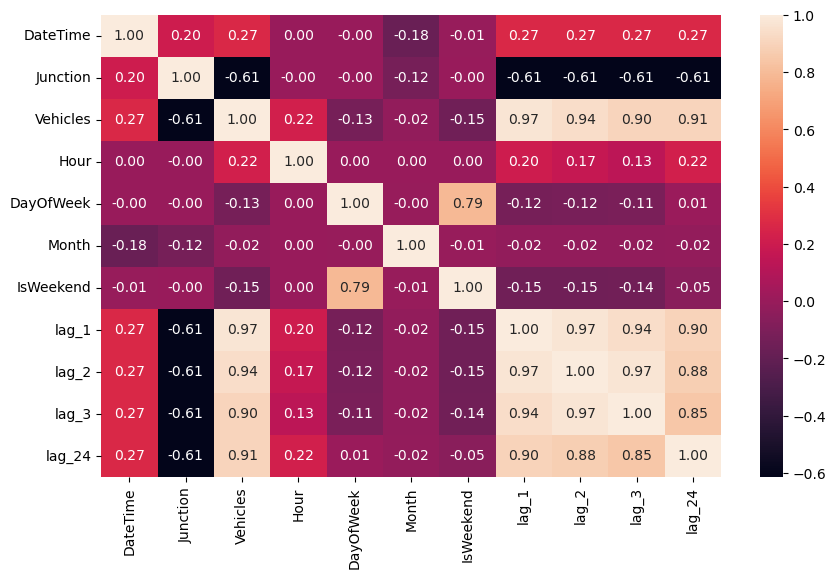

In [49]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_hourly.corr(), annot=True, fmt=".2f")
plt.show()

In [58]:
#Feature importance using RandomForest
from sklearn.ensemble import RandomForestRegressor

In [59]:
X = df_hourly.drop(columns=['Vehicles', 'DateTime'])
y = df_hourly['Vehicles']

In [66]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [67]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)

Feature Importances:
 lag_1        0.942598
Hour         0.015283
lag_24       0.014597
lag_2        0.008268
lag_3        0.007785
Month        0.004597
DayOfWeek    0.003954
Junction     0.002114
IsWeekend    0.000804
dtype: float64
